# Purpose: Predicting Optimal AFP Parameters for Targeted Mechanical Properties Using GANs Model as VSG Technique Combine With a MLP Model as Predictive Model
# Date: 05/2025
# UNSW Sydney / EPFL
# Code: Assier de Pompignan Leo

2/2 [==============================] - 1s 0s/step
Epoch 0/5000, D Loss Real: 0.7732542753219604, D Loss Fake: 0.6720177531242371, G Loss: 0.7154654264450073
2/2 [==============================] - 0s 0s/step
Epoch 500/5000, D Loss Real: 0.7258944511413574, D Loss Fake: 0.6264898777008057, G Loss: 0.8013746738433838
2/2 [==============================] - 0s 0s/step
Epoch 1000/5000, D Loss Real: 0.5803555250167847, D Loss Fake: 0.4799875319004059, G Loss: 1.0235848426818848
2/2 [==============================] - 0s 0s/step
Epoch 1500/5000, D Loss Real: 0.6847400665283203, D Loss Fake: 0.6499230861663818, G Loss: 0.7815320491790771
2/2 [==============================] - 0s 0s/step
Epoch 2000/5000, D Loss Real: 0.6635287404060364, D Loss Fake: 0.5690948963165283, G Loss: 0.8819417953491211
2/2 [==============================] - 0s 0s/step
Epoch 2500/5000, D Loss Real: 0.6636302471160889, D Loss Fake: 0.612740695476532, G Loss: 0.792037844657898
2/2 [==============================] - 0s 0s/s

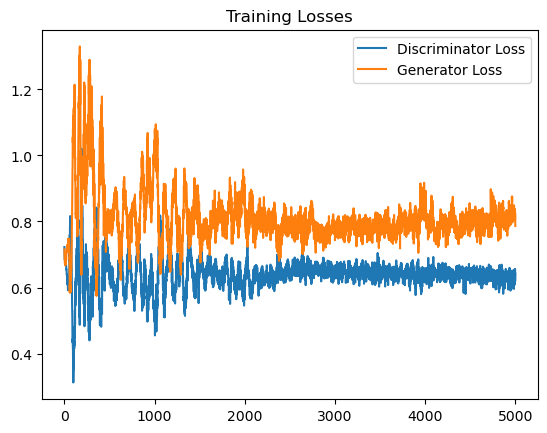

32/32 [==============================] - 0s 673us/step
Virtual samples generated and saved.


In [1]:
# WGANs Model used as a VSG Technique
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU
import matplotlib.pyplot as plt

# Parameters for GAN
num_virtual_samples = 1000
latent_dim = 10
epochs = 5000
batch_size = 64

# Load original data
data_path = 'training_dataset.xlsx'
original_data = pd.read_excel(data_path, skiprows=1)
original_data.columns = original_data.columns.str.strip()

# Select input and output columns
X_original = original_data[['Modulus (Gpa)', 'ILSS (Mpa)', 'Max bending stress (Mpa)', 'Max strain (mm/mm)', 'Thickness (mm)']].values
y_original = original_data[['Consolidation force (N)', 'Deposition rate (mm/s)', 'Hot gas torch temperature (C)']].values

# Combine data for GAN
full_data = np.concatenate([X_original, y_original], axis=1)
data_dim = full_data.shape[1]

# Normalize data
min_values = full_data.min(axis=0)
max_values = full_data.max(axis=0)
range_values = max_values - min_values
epsilon = 1e-8
range_values[range_values == 0] = epsilon
normalized_data = (full_data - min_values) / range_values

# Define GAN components
def build_generator(latent_dim, data_dim):
    model = Sequential([
        Dense(64, input_dim=latent_dim),
        LeakyReLU(0.2),
        Dense(128),
        LeakyReLU(0.2),
        Dense(data_dim, activation='sigmoid')
    ])
    return model

def build_discriminator(data_dim):
    model = Sequential([
        Dense(128, input_dim=data_dim),
        LeakyReLU(0.2),
        Dense(64),
        LeakyReLU(0.2),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def build_gan(generator, discriminator):
    discriminator.trainable = False
    model = Sequential([generator, discriminator])
    model.compile(optimizer='adam', loss='binary_crossentropy')
    return model

generator = build_generator(latent_dim, data_dim)
discriminator = build_discriminator(data_dim)
gan = build_gan(generator, discriminator)

# Training GAN
def train_gan(data, generator, discriminator, gan, epochs, batch_size, latent_dim):
    d_losses = []
    g_losses = []
    for epoch in range(epochs):
        real_samples = data[np.random.randint(0, data.shape[0], batch_size)]
        fake_samples = generator.predict(np.random.normal(0, 1, (batch_size, latent_dim)))
        real_labels = np.ones((batch_size, 1))
        fake_labels = np.zeros((batch_size, 1))
        d_loss_real = discriminator.train_on_batch(real_samples, real_labels)
        d_loss_fake = discriminator.train_on_batch(fake_samples, fake_labels)
        latent_points = np.random.normal(0, 1, (batch_size, latent_dim))
        misleading_labels = np.ones((batch_size, 1))
        g_loss = gan.train_on_batch(latent_points, misleading_labels)
        d_losses.append((d_loss_real[0] + d_loss_fake[0]) / 2)
        g_losses.append(g_loss)
        if epoch % 500 == 0:
            print(f"Epoch {epoch}/{epochs}, D Loss Real: {d_loss_real[0]}, D Loss Fake: {d_loss_fake[0]}, G Loss: {g_loss}")

    # Plot training losses
    plt.plot(d_losses, label="Discriminator Loss")
    plt.plot(g_losses, label="Generator Loss")
    plt.legend()
    plt.title("Training Losses")
    plt.show()
    
train_gan(normalized_data, generator, discriminator, gan, epochs, batch_size, latent_dim)

# Generate Virtual Samples
latent_points = np.random.normal(0, 1, (num_virtual_samples, latent_dim))
generated_data = generator.predict(latent_points)
denormalized_data = generated_data * range_values + min_values

# Split into input and output
X_vsg = denormalized_data[:, :5]
y_vsg = denormalized_data[:, 5:]

# Save data
vsg_data = pd.DataFrame(np.concatenate([X_vsg, y_vsg], axis=1),
                        columns=['Modulus (Gpa)', 'ILSS (Mpa)', 'Max bending stress (Mpa)', 'Max strain (mm/mm)', 'Thickness (mm)',
                                 'Consolidation force (N)', 'Deposition rate (mm/s)', 'Hot gas torch temperature (C)'])
vsg_data.to_csv('generated_vsg_data_gan.csv', index=False)
print("Virtual samples generated and saved.")


Epoch 1/500
26/26 [==============================] - 0s 6ms/step - loss: 0.8655 - val_loss: 0.7046
Epoch 2/500
26/26 [==============================] - 0s 3ms/step - loss: 0.6801 - val_loss: 0.5621
Epoch 3/500
26/26 [==============================] - 0s 3ms/step - loss: 0.5505 - val_loss: 0.4422
Epoch 4/500
26/26 [==============================] - 0s 3ms/step - loss: 0.4385 - val_loss: 0.3573
Epoch 5/500
26/26 [==============================] - 0s 3ms/step - loss: 0.3434 - val_loss: 0.2757
Epoch 6/500
26/26 [==============================] - 0s 3ms/step - loss: 0.2728 - val_loss: 0.2234
Epoch 7/500
26/26 [==============================] - 0s 2ms/step - loss: 0.2176 - val_loss: 0.1877
Epoch 8/500
26/26 [==============================] - 0s 3ms/step - loss: 0.1881 - val_loss: 0.1552
Epoch 9/500
26/26 [==============================] - 0s 2ms/step - loss: 0.1614 - val_loss: 0.1409
Epoch 10/500
26/26 [==============================] - 0s 3ms/step - loss: 0.1356 - val_loss: 0.1363
Epoch 11/

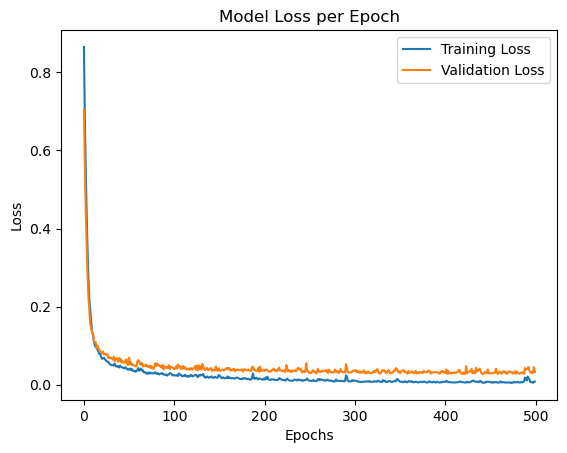

Model training complete and saved.


In [2]:
# MLP Model used as a Predictive Model
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import joblib
import matplotlib.pyplot as plt

# File paths
file_path_real = 'training_dataset.xlsx'
file_path_vsg = 'generated_vsg_data_gan.csv'

# Load real and virtual data
data_real = pd.read_excel(file_path_real, skiprows=1)
data_real.columns = data_real.columns.str.strip()

data_vsg = pd.read_csv(file_path_vsg)

# Combine data
X_combined = np.concatenate([
    data_real[['Modulus (Gpa)', 'ILSS (Mpa)', 'Max bending stress (Mpa)', 'Max strain (mm/mm)', 'Thickness (mm)']].values,
    data_vsg[['Modulus (Gpa)', 'ILSS (Mpa)', 'Max bending stress (Mpa)', 'Max strain (mm/mm)', 'Thickness (mm)']].values
], axis=0)
y_combined = np.concatenate([
    data_real[['Consolidation force (N)', 'Deposition rate (mm/s)', 'Hot gas torch temperature (C)']].values,
    data_vsg[['Consolidation force (N)', 'Deposition rate (mm/s)', 'Hot gas torch temperature (C)']].values
], axis=0)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_combined, y_combined, test_size=0.2, random_state=42)

# Scale data
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

# Train model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_dim=X_train_scaled.shape[1]),  # Layer 1
    tf.keras.layers.Dense(64, activation='relu'),                                     # Layer 2
    tf.keras.layers.Dense(32, activation='relu'),                                     # Layer 3
    tf.keras.layers.Dense(16, activation='relu'),                                     # Layer 4
    tf.keras.layers.Dense(8, activation='relu'),                                      # Layer 5
    tf.keras.layers.Dense(3)                                                          # Layer 6 (output)
])

model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(X_train_scaled, y_train_scaled, epochs=500, batch_size=32, validation_data=(X_test_scaled, y_test_scaled))

# Plot loss as a function of epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# Save model and scalers
model.save('trained_model_tf_gan.h5')
joblib.dump(scaler_X, 'scaler_X_gan.pkl')
joblib.dump(scaler_y, 'scaler_y_gan.pkl')

print("Model training complete and saved.")

In [3]:
# Inference code
import pandas as pd
import tensorflow as tf
import joblib

# Load model and scalers
model = tf.keras.models.load_model('trained_model_tf_gan.h5')
scaler_X = joblib.load('scaler_X_gan.pkl')
scaler_y = joblib.load('scaler_y_gan.pkl')

# Load new data
file_path_new = 'training_test.xlsx'
new_data = pd.read_excel(file_path_new, skiprows=1)
new_data.columns = new_data.columns.str.strip()

X_new = new_data[['Modulus (Gpa)', 'ILSS (Mpa)', 'Max bending stress (Mpa)', 'Max strain (mm/mm)', 'Thickness (mm)']].values
X_new = pd.DataFrame(X_new).fillna(X_new.mean()).values
X_new_scaled = scaler_X.transform(X_new)

# Predict
y_pred_scaled = model.predict(X_new_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled)

# Save predictions
prediction_df = pd.DataFrame(y_pred, columns=['Consolidation force (N)', 'Deposition rate (mm/s)', 'Hot gas torch temperature (C)'])
print("Predictions:")
print(prediction_df)

# File paths
output_file_path = 'predictions_GANs.xlsx'  # Output Excel file path

# Add the file name to the top of the DataFrame
file_name = file_path_new.split('/')[-1]  # Extract file name from the path
file_header = pd.DataFrame([[file_name, file_name, file_name]], columns=prediction_df.columns)  # Update for 3 columns
output_df = pd.concat([file_header, prediction_df], ignore_index=True)

# Save to Excel
output_df.to_excel(output_file_path, index=False)
print(f"Predictions saved to {output_file_path}")

1/1 [==============================] - 0s 44ms/step
Predictions:
    Consolidation force (N)  Deposition rate (mm/s)  \
0                187.106537               75.892494   
1                228.641098               77.056793   
2                249.707550               76.976456   
3                445.632904               75.775124   
4                192.147522               76.917877   
5                254.117065               76.397064   
6                337.715027               76.161293   
7                438.547516               75.586639   
8                215.956573               75.537315   
9                251.478867               76.629974   
10               326.858612               77.241875   
11               447.135040               76.288330   
12               226.806335               76.035904   
13               260.201752               75.315697   
14               349.650085               76.243797   
15               447.274292               76.238541   
